In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
from vega_datasets import data

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pandas    : 1.1.3
seaborn   : 0.11.0
sklearn   : 0.23.2
matplotlib: 3.3.2
theano    : 1.0.5
numpy     : 1.19.2
pymc3     : 3.9.3
arviz     : 0.10.0



### Robust regression

In [3]:
from sklearn.datasets import make_regression

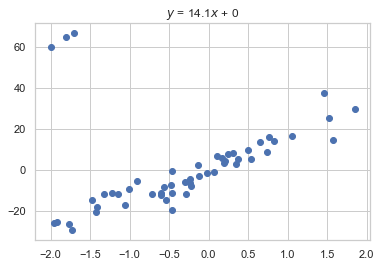

In [100]:
np.random.seed(42)
data_x, data_y, coef = make_regression(n_samples=50, n_features=1, noise=5, coef=True)
data_x = data_x.flatten()

# Add outliers
data_x = np.append(data_x, [-2, -1.8, -1.7])
data_y = np.append(data_y, [60, 65, 67])

fig, ax = plt.subplots()
ax.scatter(data_x, data_y);
ax.set(title=f'$y$ = {coef:.1f}$x$ + 0');

In [101]:
def lin_reg(x_in, y_in):
    with pm.Model() as model:
        # data
        x = pm.Data('x', x_in)
        y = pm.Data('y', y_in)

        # priors on parameters
        α = pm.Normal('α', 0, 1)
        β = pm.Normal('β', 0, 1)
        σ = pm.HalfNormal('σ', 1)

        # model
        μ = pm.Deterministic('μ', β * x + α) # unnecessary to use `Deterministic` and probably inefficient - using this just for 'prettier' graph
        y_hat = pm.Normal('y_hat', mu=μ, sigma=σ, observed=y)
    return model

def robust_reg(x_in, y_in):
    with pm.Model() as model:
        # data
        x = pm.Data('x', x_in)
        y = pm.Data('y', y_in)

        # priors on parameters
        α = pm.Normal('α', 0, 1)
        β = pm.Normal('β', 0, 1)
        σ = pm.HalfNormal('σ', 1)

        # model
        μ = pm.Deterministic('μ', β * x + α) # unnecessary to use `Deterministic` and probably inefficient - using this just for 'prettier' graph
        y_hat = pm.StudentT('y_hat', nu=1, mu=μ, sigma=σ, observed=y)
    return model

In [102]:
lm = lin_reg(data_x, data_y)
lm

In [103]:
with lm:
    # Prior sampling, trace definition and posterior sampling
    lm_prior = pm.sample_prior_predictive()
    lm_posterior = pm.sample()
    lm_posterior_pred = pm.sample_posterior_predictive(lm_posterior)
lm_inf_obj = az.from_pymc3(prior=lm_prior, trace=lm_posterior, posterior_predictive=lm_posterior_pred,
                           model=lm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [104]:
r_lm = robust_reg(data_x, data_y)
r_lm

In [105]:
with r_lm:
    # Prior sampling, trace definition and posterior sampling
    r_lm_prior = pm.sample_prior_predictive()
    r_lm_posterior = pm.sample()
    r_lm_posterior_pred = pm.sample_posterior_predictive(r_lm_posterior)
r_lm_inf_obj = az.from_pymc3(prior=r_lm_prior, trace=r_lm_posterior, posterior_predictive=r_lm_posterior_pred,
                             model=r_lm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


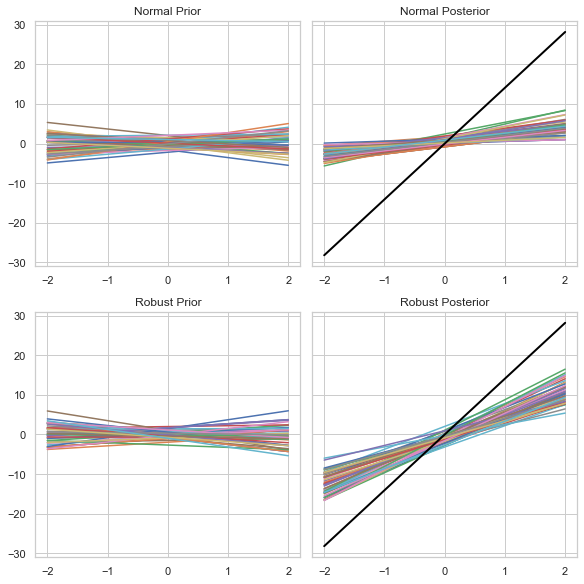

In [110]:
nshow = 50

samples = 500 # default n_samples in pymc3
idx = np.random.randint(0, samples, nshow)

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, constrained_layout=True, figsize=(8,8))

for α, β in zip(lm_inf_obj.prior.get('α').values.flatten()[idx], 
                lm_inf_obj.prior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    axes[0,0].plot(xs, β * xs + α)
axes[0,0].set(title='Normal Prior');

samples = 500 # default n_samples in pymc3
idx = np.random.randint(0, samples, nshow)

for α, β in zip(lm_inf_obj.posterior.get('α').values.flatten()[idx], 
                lm_inf_obj.posterior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    axes[0,1].plot(xs, β * xs + α)
axes[0,1].set(title='Normal Posterior');

for α, β in zip(r_lm_inf_obj.prior.get('α').values.flatten()[idx], 
                r_lm_inf_obj.prior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    axes[1,0].plot(xs, β * xs + α)
axes[1,0].set(title='Robust Prior');

samples = 500 # default n_samples in pymc3
idx = np.random.randint(0, samples, nshow)

for α, β in zip(r_lm_inf_obj.posterior.get('α').values.flatten()[idx], 
                r_lm_inf_obj.posterior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    axes[1,1].plot(xs, β * xs + α)
axes[1,1].set(title='Robust Posterior');


axes[0,1].plot(xs, xs * coef, linewidth=2, color='black')
axes[1,1].plot(xs, xs * coef, linewidth=2, color='black')

# for ax in (ax1,ax2):
#     ax.set(aspect='equal')

In [111]:
az.summary(lm_inf_obj, var_names=['~μ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.552,0.863,-1.078,2.138,0.012,0.012,5430.0,2677.0,5438.0,2800.0,1.0
β,1.764,0.839,0.126,3.194,0.011,0.009,5506.0,4751.0,5514.0,3139.0,1.0
σ,11.207,0.461,10.359,12.084,0.006,0.004,5280.0,5269.0,5270.0,2785.0,1.0


In [112]:
az.summary(r_lm_inf_obj, var_names=['~μ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.872,0.874,-2.538,0.711,0.013,0.012,4292.0,2697.0,4268.0,2465.0,1.0
β,6.019,1.187,3.755,8.141,0.021,0.015,3234.0,3176.0,3205.0,2198.0,1.0
σ,3.992,0.580,2.950,5.112,0.011,0.007,3004.0,3004.0,2972.0,2231.0,1.0


In [113]:
coef

array(14.0924225)

### $L_1$ regularization

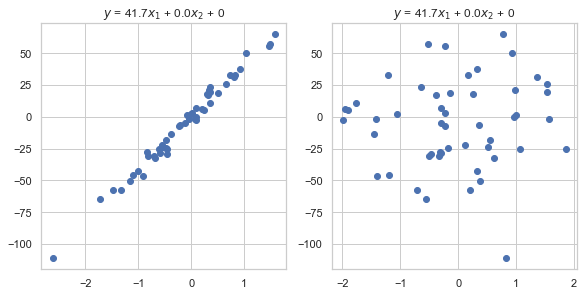

In [116]:
np.random.seed(42)
data_x, data_y, coef = make_regression(n_samples=50, n_features=2, n_informative=1, noise=5, coef=True)

fig, axes = plt.subplots(ncols=2, constrained_layout=True, figsize=(8,4))

axes[0].scatter(data_x[:,0], data_y);
axes[1].scatter(data_x[:,1], data_y);

for ax in axes:
    ax.set(title=f'$y$ = {coef[0]:.1f}$x_1$ + {coef[1]:.1f}$x_2$ + 0');

In [118]:
def multi_reg_l2(x_in, y_in):
    with pm.Model() as model:
        # data
        x = pm.Data('x', x_in)
        y = pm.Data('y', y_in)

        # priors on parameters
        α = pm.Normal('α', 0, 1)
        β = pm.Normal('β', 0, 1, shape=x_in.shape[1])
        σ = pm.HalfNormal('σ', 1)

        # model
        μ = pm.Deterministic('μ', x @ β + α) # matrix multiplication here is neccessary
        y_hat = pm.Normal('y_hat', mu=μ, sigma=σ, observed=y)
    return model

def multi_reg_l1(x_in, y_in):
    with pm.Model() as model:
        # data
        x = pm.Data('x', x_in)
        y = pm.Data('y', y_in)

        # priors on parameters
        α = pm.Laplace('α', 0, 1)
        β = pm.Laplace('β', 0, 1, shape=x_in.shape[1])
        σ = pm.HalfNormal('σ', 1)

        # model
        μ = pm.Deterministic('μ', x @ β + α) # matrix multiplication here is neccessary
        y_hat = pm.Normal('y_hat', mu=μ, sigma=σ, observed=y)
    return model

In [129]:
l1_lm = multi_reg_l1(data_x, data_y)
l1_lm

In [130]:
with l1_lm:
    # Prior sampling, trace definition and posterior sampling
    l1_lm_prior = pm.sample_prior_predictive()
    l1_lm_posterior = pm.sample()
    l1_lm_posterior_pred = pm.sample_posterior_predictive(l1_lm_posterior)
l1_lm_inf_obj = az.from_pymc3(prior=l1_lm_prior, trace=l1_lm_posterior, posterior_predictive=l1_lm_posterior_pred,
                              model=l1_lm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [131]:
l2_lm = multi_reg_l2(data_x, data_y)
l2_lm

In [132]:
with l2_lm:
    # Prior sampling, trace definition and posterior sampling
    l2_lm_prior = pm.sample_prior_predictive()
    l2_lm_posterior = pm.sample()
    l2_lm_posterior_pred = pm.sample_posterior_predictive(l2_lm_posterior)
l2_lm_inf_obj = az.from_pymc3(prior=l2_lm_prior, trace=l2_lm_posterior, posterior_predictive=l2_lm_posterior_pred,
                              model=l2_lm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [133]:
az.summary(l1_lm_inf_obj, var_names=['~μ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.170,0.454,-1.102,0.641,0.007,0.007,3816.0,2414.0,3919.0,2867.0,1.0
β[0],41.168,0.660,39.908,42.383,0.010,0.007,4540.0,4539.0,4551.0,3288.0,1.0
β[1],0.675,0.504,-0.183,1.664,0.007,0.006,4848.0,3807.0,4879.0,3531.0,1.0
σ,3.775,0.309,3.196,4.354,0.005,0.003,4244.0,4200.0,4198.0,2937.0,1.0


In [134]:
az.summary(l2_lm_inf_obj, var_names=['~μ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-1.038,0.895,-2.806,0.541,0.012,0.010,5712.0,3776.0,5724.0,3103.0,1.0
β[0],6.583,1.014,4.682,8.431,0.016,0.011,4272.0,4233.0,4271.0,3066.0,1.0
β[1],0.495,0.895,-1.178,2.179,0.012,0.012,5694.0,2728.0,5712.0,3185.0,1.0
σ,13.620,0.518,12.642,14.589,0.008,0.006,4395.0,4386.0,4409.0,3267.0,1.0


In [135]:
coef

array([41.74110031,  0.        ])